# Flames - Extended Feature Selection
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Jan 14, 2022

## Hypothesis
Two very important components of a machine learning model are feature selection and feature engineering. Our idea is that adding some more features to the StellarAlgo retention model could improve performance of the model. This notebook will test the standard StellarAlgo retention model features.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '52.44.171.130' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 36 # flames
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrFlames].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(38819, 58)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38819 entries, 0 to 38818
Data columns (total 58 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lkupClientId              38819 non-null  int64  
 1   dimCustomerMasterId       38819 non-null  int64  
 2   customerNumber            38819 non-null  object 
 3   year                      38819 non-null  int64  
 4   productGrouping           38819 non-null  object 
 5   totalSpent                38819 non-null  float64
 6   recentDate                38819 non-null  object 
 7   attendancePercent         38819 non-null  float64
 8   renewedBeforeDays         38818 non-null  float64
 9   isBuyer                   38819 non-null  object 
 10  source_tenure             38819 non-null  int64  
 11  tenure                    38818 non-null  float64
 12  distToVenue               38819 non-null  float64
 13  totalGames                38819 non-null  int64  
 14  recenc

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
    "attendancePercent",
    "clickToOpenRatio", 
    "clickToSendRatio",
    "distToVenue",
    "inperson_contact",
    "isNextYear_Buyer",
    "missed_games_1",
    "missed_games_2",
    "missed_games_over_2",
    "openToSendRatio",
    "productGrouping",
    "recency",
    "renewedBeforeDays",
    "source_tenure",
    "totalSpent",
    "is_Lockdown",
    "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (28573, 18)
Unseen Data For Predictions: (5042, 18)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
    "clickToOpenRatio", 
    "clickToSendRatio",
    "distToVenue",
    "inperson_contact",
    "missed_games_1",
    "missed_games_2",
    "missed_games_over_2",
    "openToSendRatio",
    "recency",
    "renewedBeforeDays",
    "source_tenure",
    "is_Lockdown",
    "totalSpent"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9211,0.9345,0.9795,0.9135,0.9453,0.8042,0.8106,0.8050
lr,Logistic Regression,0.9076,0.9219,0.9799,0.8971,0.9366,0.7674,0.7783,0.3820


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9197,0.9309,0.9787,0.9124,0.9444,0.8007,0.8071
1,0.9135,0.9306,0.9734,0.9089,0.9400,0.7858,0.7918
2,0.9259,0.9383,0.9781,0.9204,0.9484,0.8174,0.8222
3,0.9135,0.9370,0.9805,0.9035,0.9404,0.7837,0.7925
4,0.9263,0.9354,0.9799,0.9195,0.9488,0.8181,0.8233
5,0.9230,0.9456,0.9811,0.9146,0.9466,0.8090,0.8155
6,0.9160,0.9225,0.9834,0.9043,0.9422,0.7896,0.7989
7,0.9201,0.9295,0.9793,0.9124,0.9447,0.8016,0.8081
8,0.9329,0.9367,0.9840,0.9244,0.9533,0.8343,0.8395
9,0.9197,0.9384,0.9763,0.9142,0.9442,0.8013,0.8069


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(5204, 58)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,pkgupgrade_status,auto_renewal,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
33615,36,162,115379,2021,Full Season,3967.22,2021-12-11,1.10,28.0,TRUE,...,0,0,0.00,1,45,4,0,0,0.9999,0.0001
33616,36,276,103521,2021,Full Season,12419.88,2021-12-11,1.00,28.0,TRUE,...,0,0,0.00,1,45,4,0,0,0.9991,0.0009
33617,36,403,108152,2021,Full Season,10807.72,2021-12-11,1.10,28.0,TRUE,...,0,0,0.00,1,45,4,0,0,0.9987,0.0013
33618,36,602,301911,2021,Full Season,12419.88,2021-12-11,1.00,28.0,TRUE,...,0,0,0.00,1,45,4,0,0,0.9982,0.0018
33619,36,2092,5208062,2021,Full Season,3967.22,2021-12-11,0.55,98.0,TRUE,...,0,0,2144.82,1,45,4,0,0,0.9999,0.0001


In [11]:
new_predictions["Label"].value_counts()

0    5204
Name: Label, dtype: int64

In [12]:
#new_predictions = new_predictions.loc[new_predictions["productGrouping"] == "Full Season"]

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

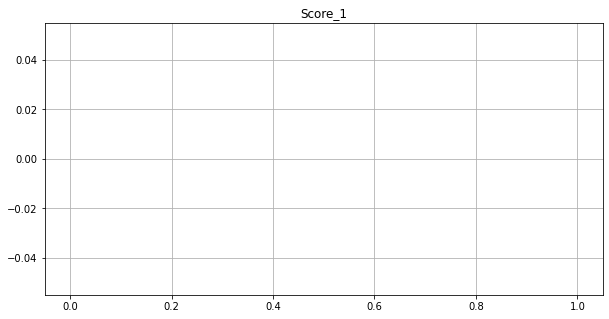

In [13]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

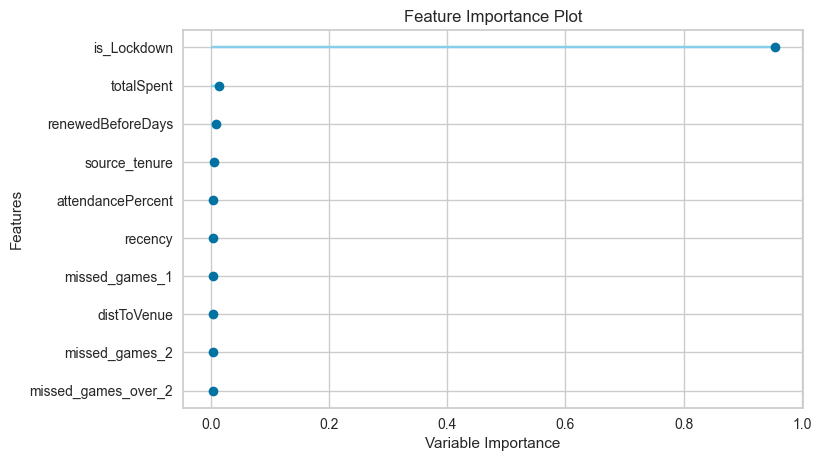

In [14]:
plot_model(best_model, plot='feature')

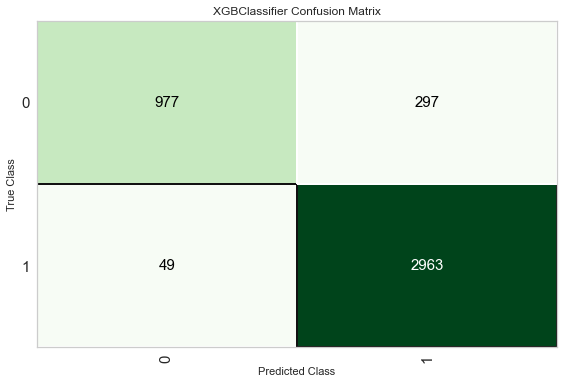

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?